In [2]:
import random
import pandas as pd

In [1]:
import torch
from pathlib import Path
import re
import os
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio as Audio

from src.model import ConvCount, config       # import model and config
from src.predict import *                     # lots of helpers
from src.utils.SpectrogramExtractor import SpectrogramExtractor

model = load_model('src\model\ConvCount_full.pt')      # loads ConvCount with config

In [2]:
long_wav = r'data/author_data/Test1/CoffeeTest1.wav'     # original audio
clips_dir = r'data/author_data/Test1/clips'        # trimmed clips destination
specs_dir = r'data/author_data/Test1/specs'        # spectrograms destination

#save_wav_as_clips(long_wav, out_dir=clips_dir)
clips_to_specs(clips_dir=clips_dir, specs_dir=specs_dir)

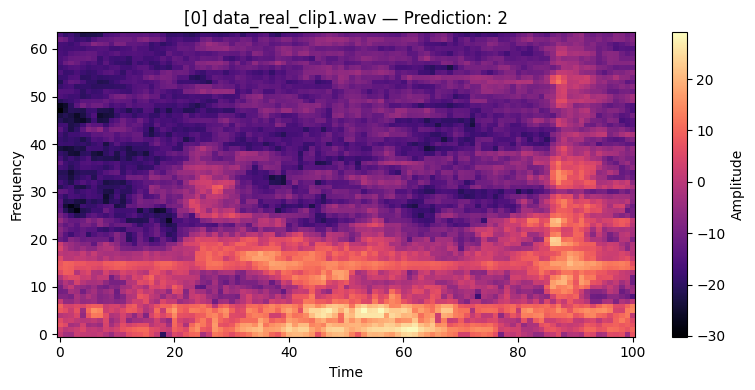

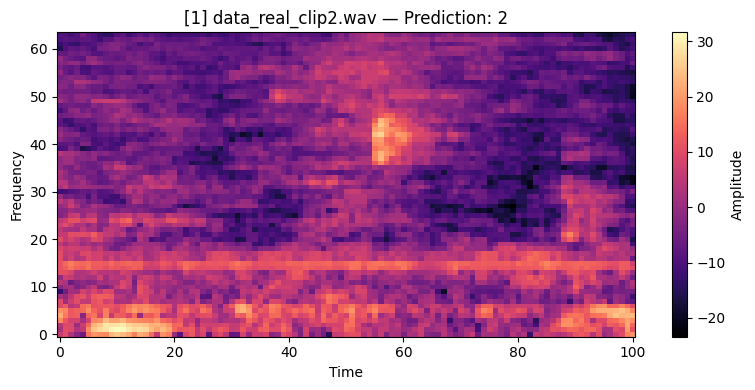

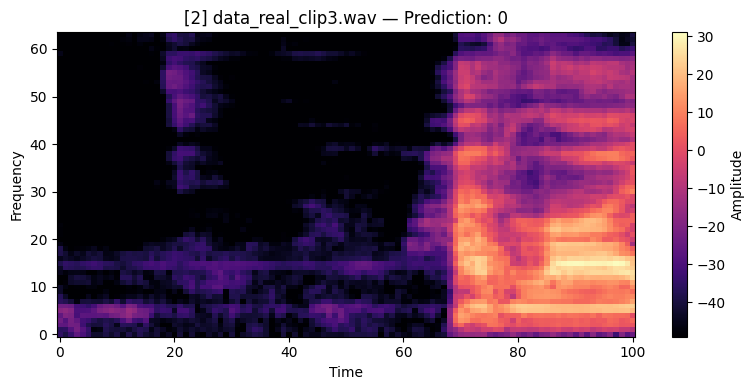

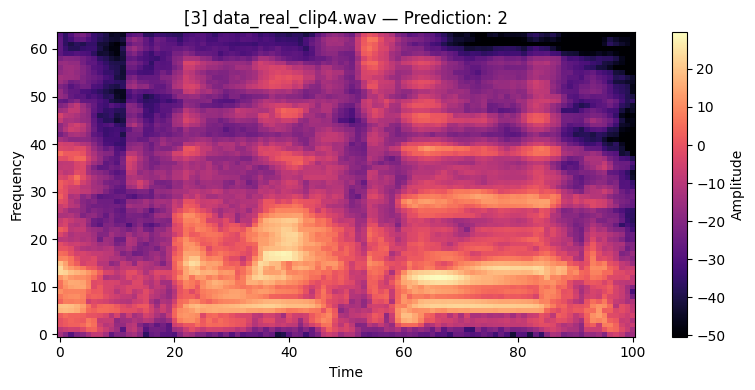

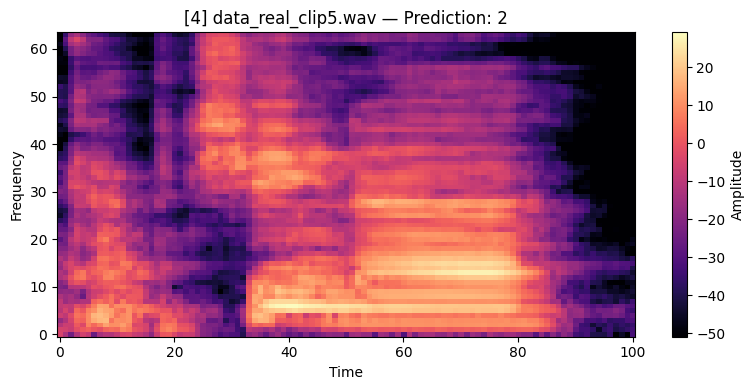

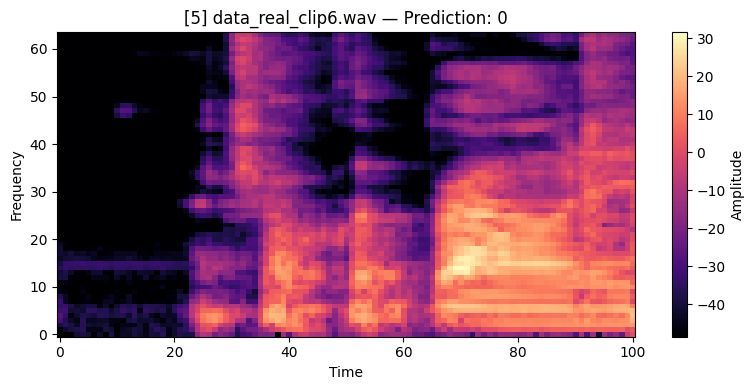

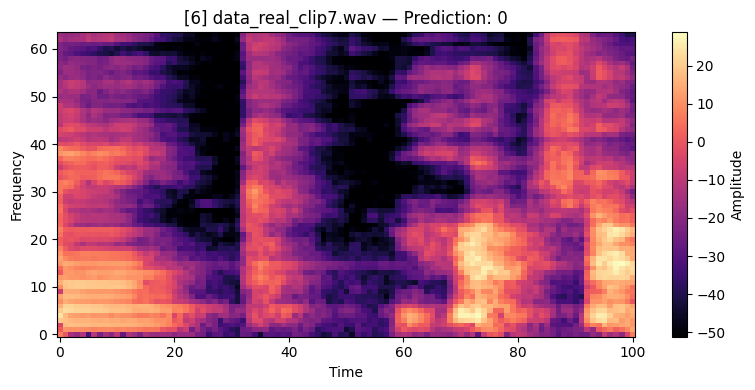

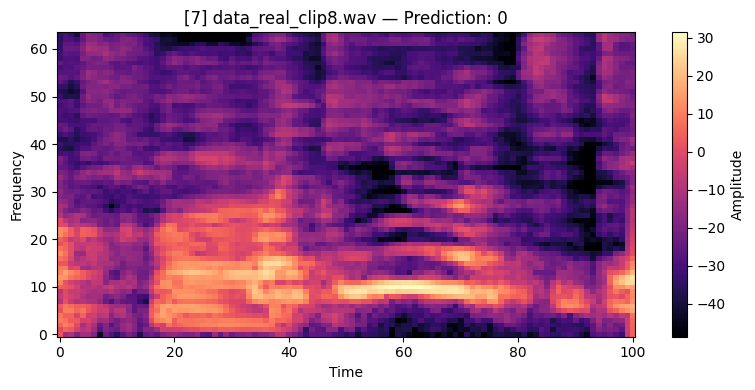

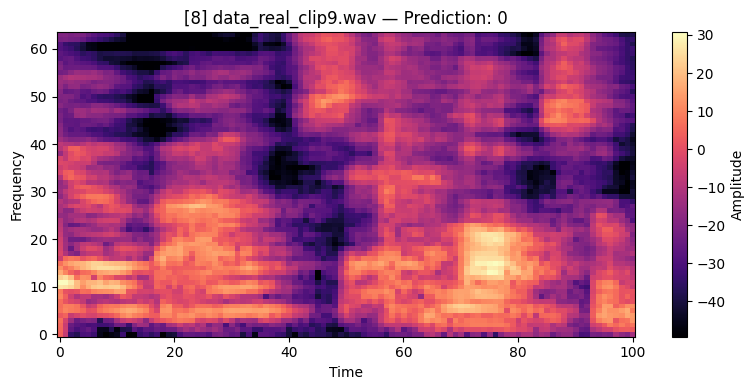

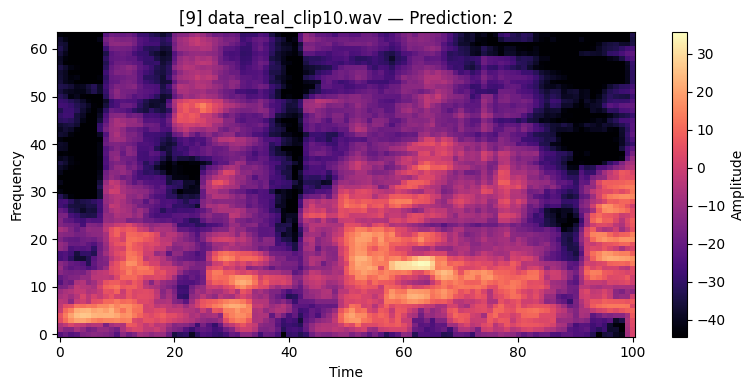

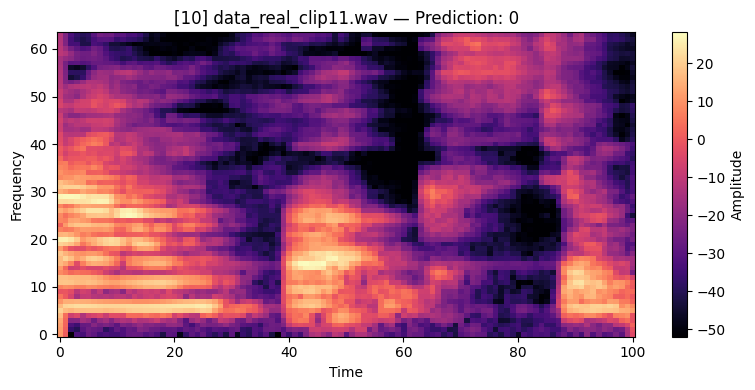

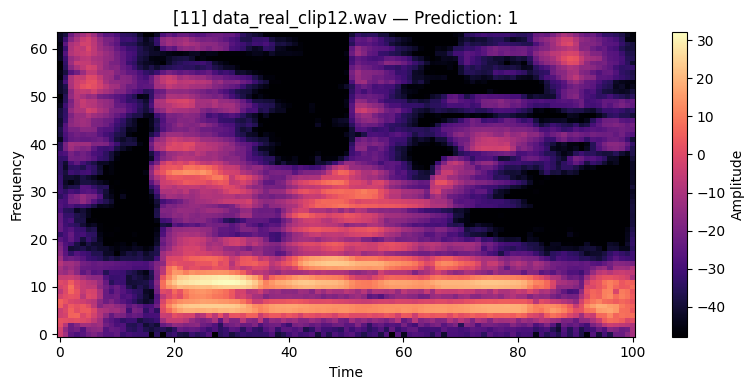

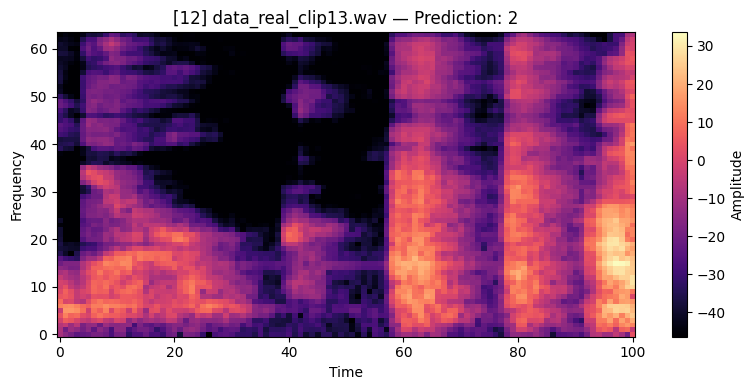

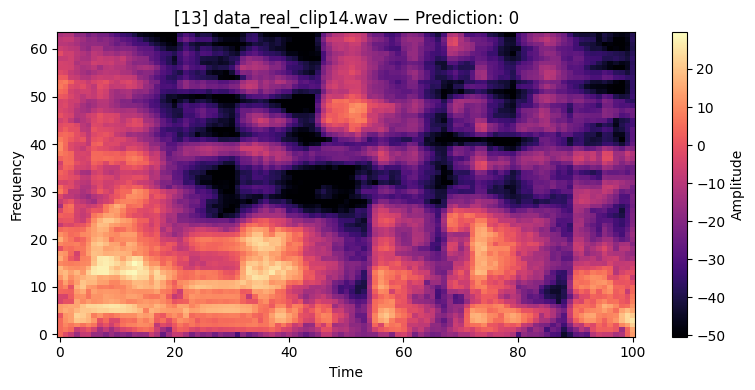

In [3]:
def natural_key(filename):
    # Extracts numeric parts of the filename for natural sorting
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('(\d+)', filename)]

for idx, spec_name in enumerate(sorted(os.listdir(specs_dir), key=natural_key)):
    if spec_name.endswith('.pt'):
        spec_path = os.path.join(specs_dir, spec_name)
        clip_name = spec_name.replace('.pt', '.wav')
        clip_path = os.path.join(clips_dir, clip_name)

        prediction = predict(spec_path, model)
        spec = load_spectrogram(spec_path).squeeze()  # adjust shape if needed

        # Show spectrogram
        plt.figure(figsize=(8, 4))
        plt.imshow(spec.numpy(), aspect='auto', origin='lower', cmap='magma')
        plt.title(f"[{idx}] {clip_name} — Prediction: {prediction}", fontsize=12)
        plt.colorbar(label='Amplitude')
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # Play corresponding audio
        display(Audio(clip_path))


In [ ]:
import librosa, numpy as np, glob, os
def feature_stats(path, sr=16000, n_fft=512, hop=160, n_mels=64):
    x, _ = librosa.load(path, sr=sr, mono=True)
    rms = np.sqrt(np.mean(x**2))
    S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    logmel = 10*np.log10(mel + 1e-12)
    return {'file':os.path.basename(path),
            'sr':sr, 'len_s':len(x)/sr,
            'rms':rms, 'logmel_mean':float(np.mean(logmel)),
            'logmel_std':float(np.std(logmel)),
            'logmel_min':float(np.min(logmel)), 'logmel_max':float(np.max(logmel)),
            'shape':logmel.shape}
# Compare one train file vs your real file
train = r"data\clips_libricss\0L_session0_clip16.wav"
real  = r"data\author_data\Test1\clips\data_real_clip9.wav"
print(feature_stats(train))
print(feature_stats(real))

{'file': '0L_session0_clip16.wav', 'sr': 16000, 'len_s': 1.0, 'rms': np.float32(0.0006466342), 'logmel_mean': -74.76355743408203, 'logmel_std': 15.00100326538086, 'logmel_min': -100.55523681640625, 'logmel_max': -30.380611419677734, 'shape': (64, 101)}
{'file': 'data_real_clip9.wav', 'sr': 16000, 'len_s': 1.0, 'rms': np.float32(0.041171905), 'logmel_mean': -40.45492172241211, 'logmel_std': 17.87378692626953, 'logmel_min': -92.40171813964844, 'logmel_max': 6.692312240600586, 'shape': (64, 101)}


In [10]:
import librosa, numpy as np, soundfile as sf

def rms(x): return np.sqrt(np.mean(x**2))

def scale_to_target_rms(path_in, path_out, target_rms):
    x, sr = librosa.load(path_in, sr=16000, mono=True)
    cur = rms(x) + 1e-12
    gain = target_rms / cur
    x2 = x * gain
    sf.write(path_out, x2, sr)
    return cur, target_rms, gain, 20*np.log10(gain)

# Example: use training-file RMS (0.0006466342) as target
cur, targ, gain, gain_db = scale_to_target_rms("data_real_clip9.wav",
                                               "data_real_clip9_scaled.wav",
                                               0.0006466342)
print("cur_rms", cur, "target", targ, "gain", gain, "gain_db", gain_db)


C:\Users\conno\AppData\Local\Temp\ipykernel_19984\1621477013.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load(path_in, sr=16000, mono=True)
c:\Users\conno\Desktop\UoB_Project\cxb1114\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'data_real_clip9.wav'

In [11]:
import random, glob, os, numpy as np, pandas as pd, soundfile as sf
from pathlib import Path

def list_wavs(pattern):
    p = Path(pattern)
    if "*" in pattern or "?" in pattern:
        return sorted(glob.glob(str(p)))
    return [str(p)] if p.exists() else []

def file_rms_db(path):
    try:
        x, sr = sf.read(path, dtype='float32')
    except Exception as e:
        return None, None, None
    if x is None or x.size == 0:
        return 0.0, sr, -np.inf
    if x.ndim > 1:
        x = np.mean(x, axis=1)
    rms = float(np.sqrt(np.mean(x.astype('float64')**2)))
    db = float(20.0 * np.log10(rms + 1e-12))
    return rms, sr, db

def gather_stats(paths):
    rows = []
    for p in paths:
        rms, sr, db = file_rms_db(p)
        rows.append({'file': os.path.basename(p), 'path': p, 'sr': sr, 'rms': rms, 'db': db})
    return pd.DataFrame(rows)

a_pattern = r"data\author_data\Test1\clips\*.wav"
b_pattern = r"data\clips_aug\*.wav"

a_files = list_wavs(a_pattern)
b_files = list_wavs(b_pattern)

if len(b_files) > 50:
    random.seed(42)
    b_sample = random.sample(b_files, 50)
else:
    b_sample = b_files

df_a = gather_stats(a_files)
df_b = gather_stats(b_sample)

def summary(df):
    if df.empty:
        return {}
    return {
        'count': int(len(df)),
        'mean_rms': float(df['rms'].mean()),
        'median_rms': float(df['rms'].median()),
        'std_rms': float(df['rms'].std()),
        'min_rms': float(df['rms'].min()),
        'max_rms': float(df['rms'].max()),
        'mean_db': float(df['db'].mean()),
        'median_db': float(df['db'].median()),
        'std_db': float(df['db'].std()),
        'min_db': float(df['db'].min()),
        'max_db': float(df['db'].max()),
    }

s_a = summary(df_a)
s_b = summary(df_b)

summary_df = pd.DataFrame([s_a, s_b], index=['author_data/Test1/clips', 'clips_aug (50 sample)'])
print(summary_df.to_string())

out_dir = Path('volume_stats_output')
out_dir.mkdir(exist_ok=True)
df_a.to_csv(out_dir / 'author_data_Test1_clips_perfile.csv', index=False)
df_b.to_csv(out_dir / 'clips_aug_sample_perfile.csv', index=False)
summary_df.to_csv(out_dir / 'volume_summary_compare.csv')
print(f"Saved per-file CSVs and summary to {out_dir.resolve()}")


                         count  mean_rms  median_rms   std_rms   min_rms   max_rms    mean_db  median_db     std_db     min_db     max_db
author_data/Test1/clips     14  0.032209    0.035721  0.019934  0.000261  0.067969 -35.051195 -28.966706  15.055371 -71.679270 -23.353738
clips_aug (50 sample)       50  0.187274    0.184027  0.033719  0.129836  0.303746 -14.683615 -14.702524   1.529039 -17.732105 -10.349787
Saved per-file CSVs and summary to C:\Users\conno\Desktop\UoB_Project\cxb1114\volume_stats_output


In [14]:
import glob, os, random, numpy as np, pandas as pd, soundfile as sf
from pathlib import Path

def list_wavs(pattern):
    return sorted(glob.glob(str(Path(pattern))))

def file_rms_db(path):
    try:
        x, sr = sf.read(path, dtype='float32')
    except Exception as e:
        return None, None, None
    if x.ndim > 1:
        x = np.mean(x, axis=1)
    rms = float(np.sqrt(np.mean(x**2)))
    db = float(20.0 * np.log10(rms + 1e-12))
    return rms, sr, db

def gather_stats(files, label=""):
    rows = []
    for i, f in enumerate(files, 1):
        rms, sr, db = file_rms_db(f)
        rows.append({'file': os.path.basename(f), 'path': f, 'sr': sr, 'rms': rms, 'db': db})
        if i % 1000 == 0:
            print(f"[{label}] Processed {i}/{len(files)} files...")
    return pd.DataFrame(rows)

def summary(df):
    return {
        'count': len(df),
        'mean_rms': df['rms'].mean(),
        'median_rms': df['rms'].median(),
        'std_rms': df['rms'].std(),
        'min_rms': df['rms'].min(),
        'max_rms': df['rms'].max(),
        'mean_db': df['db'].mean(),
        'median_db': df['db'].median(),
        'std_db': df['db'].std(),
        'min_db': df['db'].min(),
        'max_db': df['db'].max()
    }

# Paths
clips_aug = list_wavs(r"data\clips_aug\*.wav")
clips_libricss = list_wavs(r"data\clips_libricss\*.wav")

# Sample 5k from each
random.seed(42)
clips_aug_sample = random.sample(clips_aug, min(5000, len(clips_aug)))
clips_lib_sample = random.sample(clips_libricss, min(5000, len(clips_libricss)))

df_aug = gather_stats(clips_aug_sample, label="clips_aug")
df_lib = gather_stats(clips_lib_sample, label="clips_libricss")

df_all = pd.concat([df_aug, df_lib], ignore_index=True)
sum_all = summary(df_all)

print("\nSummary — 10,000 Random Training Clips")
print(pd.Series(sum_all))

# Save per-file details
out_dir = Path("volume_stats_output")
out_dir.mkdir(exist_ok=True)
df_all.to_csv(out_dir / "training_sample_perfile.csv", index=False)
print(f"Saved per-file stats to {out_dir/'training_sample_perfile.csv'}")

[clips_aug] Processed 1000/5000 files...
[clips_aug] Processed 2000/5000 files...
[clips_aug] Processed 3000/5000 files...
[clips_aug] Processed 4000/5000 files...
[clips_aug] Processed 5000/5000 files...
[clips_libricss] Processed 1000/5000 files...
[clips_libricss] Processed 2000/5000 files...
[clips_libricss] Processed 3000/5000 files...
[clips_libricss] Processed 4000/5000 files...
[clips_libricss] Processed 5000/5000 files...

Summary — 10,000 Random Training Clips
count         10000.000000
mean_rms          0.094373
median_rms        0.041054
std_rms           0.096257
min_rms           0.000208
max_rms           0.392676
mean_db         -34.762441
median_db       -30.472514
std_db           20.536065
min_db          -73.655576
max_db           -8.119320
dtype: float64
Saved per-file stats to volume_stats_output\training_sample_perfile.csv
